In [1]:
import pandas as pd
from pathlib import Path

ROOT = Path("..").resolve()  # adjust if needed
PROC = ROOT / "data" / "processed" / "barber"

r1 = pd.read_csv(PROC / "barber_r1_GR86-002-000_lap_features.csv")
r2 = pd.read_csv(PROC / "barber_r2_GR86-002-000_lap_features.csv")

r1["race_id"] = "R1"
r2["race_id"] = "R2"

laps = pd.concat([r1, r2], ignore_index=True)
laps.head()

,lap,lap_start_time,lap_end_time,lap_time_s,aps_mean,aps_max,pbrake_f_mean,pbrake_f_max,pbrake_r_mean,pbrake_r_max,sector1_time_s,sector2_time_s,sector3_time_s,is_race_pace_lap,race_id
0,2,2025-09-05 00:27:38.589000+00:00,2025-09-05 00:28:20.593000+00:00,42.004,26.141171,100.0,0.752301,14.300,0.778435,14.30,NaN,NaN,41.875,False,R1
1,3,2025-09-05 00:28:20.636000+00:00,2025-09-05 00:30:04.308000+00:00,103.672,61.772977,100.0,5.103972,144.560,5.157536,144.80,27.389,42.936,32.572,True,R1
2,4,2025-09-05 00:30:04.352000+00:00,2025-09-05 00:32:19.808000+00:00,135.456,16.254530,100.0,0.271696,15.565,0.280175,15.96,37.317,59.750,135.456,False,R1
3,5,2025-09-05 00:32:19.852000+00:00,2025-09-05 00:34:21.461000+00:00,121.609,35.266606,100.0,1.936618,78.115,1.976314,78.24,32.582,51.608,36.686,True,R1
4,6,2025-09-05 00:34:21.510000+00:00,2025-09-05 00:36:00.198000+00:00,98.688,73.468116,100.0,4.915000,117.455,4.969428,117.84,26.330,42.526,98.645,False,R1


In [2]:
# Lap number
if "lap_no" not in laps.columns:
    # try to infer
    lap_col = [c for c in laps.columns if "lap" in c.lower()][0]
    laps["lap_no"] = laps[lap_col].astype(int)

# Lap time
if "lap_time_s" not in laps.columns:
    time_col = [c for c in laps.columns if "time" in c.lower()][0]
    laps["lap_time_s"] = laps[time_col].astype(float)

# Stint lap
if "stint_lap" not in laps.columns:
    laps["stint_lap"] = laps["lap_no"]  # simple fallback

# Pit lap flag
pit_cols = [c for c in laps.columns if "pit" in c.lower() and "time" not in c.lower()]
if pit_cols:
    laps["is_pit_lap"] = laps[pit_cols[0]].astype(bool)
else:
    laps["is_pit_lap"] = False

In [3]:
# Drop laps with insane times (e.g. > 2x median)
med = laps["lap_time_s"].median()
laps = laps[laps["lap_time_s"] < 2.0 * med].copy()

# Drop explicit pit laps from training (we want pure green flag race pace)
laps = laps[~laps["is_pit_lap"]].copy()

laps = laps.sort_values(["race_id", "lap_no"]).reset_index(drop=True)

In [4]:
laps = laps.sort_values(["race_id", "lap_no"])

# shift within each race
laps["next_lap_time_s"] = laps.groupby("race_id")["lap_time_s"].shift(-1)

# drop last lap of each race (no label)
laps = laps.dropna(subset=["next_lap_time_s"]).copy()

In [5]:
laps["lap_time_ma3"] = (
    laps.groupby("race_id")["lap_time_s"]
        .rolling(3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
)

laps["lap_time_std3"] = (
    laps.groupby("race_id")["lap_time_s"]
        .rolling(3, min_periods=2)
        .std()
        .reset_index(level=0, drop=True)
)

laps["delta_vs_ma3"] = laps["lap_time_s"] - laps["lap_time_ma3"]

In [6]:
laps["stint_lap_norm"] = laps["stint_lap"] / laps["stint_lap"].max()
laps["lap_no_norm"]   = laps["lap_no"] / laps["lap_no"].max()

In [7]:
feature_cols = [
    "lap_time_s",
    "lap_time_ma3",
    "lap_time_std3",
    "delta_vs_ma3",
    "stint_lap",
    "stint_lap_norm",
    "lap_no",
    "lap_no_norm",
    # add sector times if available:
    # "s1_time", "s2_time", "s3_time",
]

target_col = "next_lap_time_s"

X = laps[feature_cols].copy()
y = laps[target_col].astype(float).copy()

In [8]:
from sklearn.model_selection import train_test_split

# e.g. 80% of laps for train, 20% for test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("MAE (s):", mae)
print("R^2:", r2)

MAE (s): 0.9897451515151943
R^2: -6.399753220336012


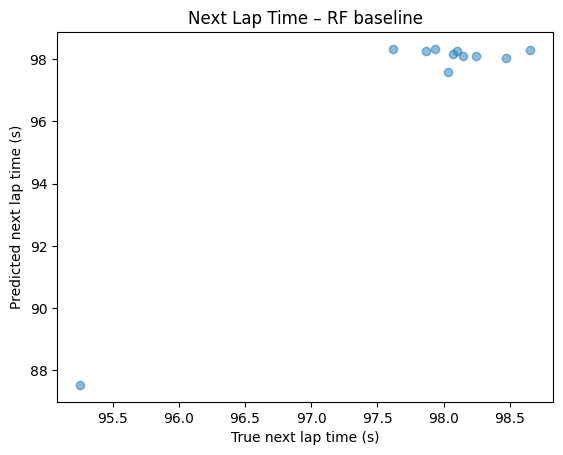

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True next lap time (s)")
plt.ylabel("Predicted next lap time (s)")
plt.title("Next Lap Time – RF baseline")
plt.show()

NameError: name '__file__' is not defined

In [16]:
import sys
from pathlib import Path

# Go one level up from the notebooks folder to the project root
PROJECT_ROOT = Path("..").resolve()

# Add project root to Python path if not already there
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PYTHONPATH updated, project root:", PROJECT_ROOT)

PYTHONPATH updated, project root: /Users/macbook/Desktop/FPTAI/DataScienceHackbyToyota


In [22]:
from src.predictive_models import train_lap_time_model, save_lap_time_model

In [24]:
from pathlib import Path
import pandas as pd

# Notebook is in /notebooks, so project root is ..
PROJECT_ROOT = Path("..").resolve()

lap_features_path = (
    PROJECT_ROOT
    / "data"
    / "processed"
    / "barber"
    / "barber_r2_GR86-002-000_lap_features.csv"
)

laps = pd.read_csv(lap_features_path)
print(lap_features_path)
laps.head()

/Users/macbook/Desktop/FPTAI/DataScienceHackbyToyota/data/processed/barber/barber_r2_GR86-002-000_lap_features.csv


,lap,lap_time_s,aps_mean,pbrake_f_mean
0,1,48.881,23.522221,0.895405
1,2,99.942,72.796897,6.024207
2,3,98.273,73.407242,6.136192
3,4,98.130,73.132636,6.994510
4,5,97.759,74.514511,8.042680


In [25]:
print(laps.columns)
print("Number of laps:", len(laps))

Index(['lap', 'lap_time_s', 'aps_mean', 'pbrake_f_mean'], dtype='object')
Number of laps: 28


In [26]:
model_bundle, metrics = train_lap_time_model(
    laps,
    track_id="barber",
    car_id="GR86-002-000",
)

metrics

TypeError: train_lap_time_model() got an unexpected keyword argument 'track_id'